<a href="https://colab.research.google.com/github/jianfeiZhao/Machine-Learning-basic/blob/master/FromLinearToRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#% matplotlib inline

# load data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/flights.csv")
print(data.head())

   year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121


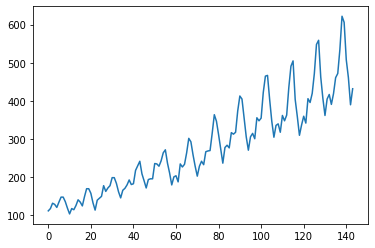

In [0]:
# plot the number of passengers of each month
dataset_ori = data['passengers'].values.astype('float32')
plt.plot(dataset_ori)
plt.show()

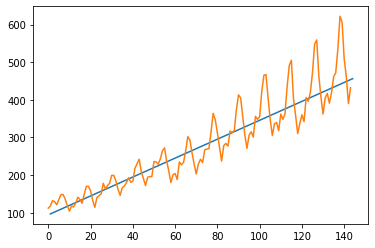

In [0]:
# linear regression
from sklearn import linear_model 
model = linear_model.LinearRegression()

y = data['passengers']
x = [[x] for x in range(1, len(y)+1)]

train_size = int(len(x) * 0.8)
train_x = x[:train_size]
train_y = y[:train_size]

model.fit(train_x, train_y)
y = model.predict(x)

plt.plot(x, y)
plt.plot(dataset_ori)
plt.show()

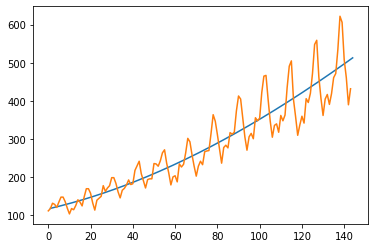

In [0]:
# non-linear regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
x_poly = poly_reg.fit_transform(x)
train_x_poly = x_poly[:train_size]

model = linear_model.LinearRegression()
model.fit(train_x_poly, train_y)
y = model.predict(x_poly)

plt.plot(x, y)
plt.plot(dataset_ori)
plt.show()

RNN

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# load data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flights.csv')
dataset_ori = data['passengers'].values.astype('float32')

# data normalization
max_value = np.max(dataset_ori)
min_value = np.min(dataset_ori)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset_ori))

look_back: 过去多少个月的乘客数

dataX: 生成的数据集X

dataY: 下一个月的乘客数

Epoch:100, Loss:0.00300
Epoch:200, Loss:0.00189
Epoch:300, Loss:0.00151
Epoch:400, Loss:0.00146
Epoch:500, Loss:0.00143
Epoch:600, Loss:0.00139
Epoch:700, Loss:0.00136
Epoch:800, Loss:0.00131
Epoch:900, Loss:0.00122
Epoch:1000, Loss:0.00110


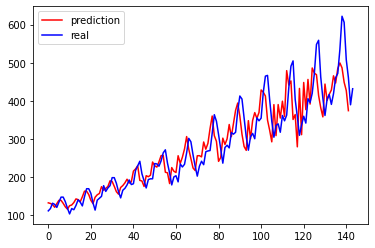

In [6]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)              # the number of several months back
        dataY.append(dataset[i + look_back])  # the number of current month
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) * 0.7)
Xtrain = data_X[:train_size]
Ytrain = data_Y[:train_size]
#print(train_X)

# define model
import torch
from torch import nn
class rnn_model(nn.Module):
  def __init__(self):
    super(rnn_model, self).__init__()
    input_size, hidden_size, output_size=2, 4, 1
    num_layers = 1
    #self.rnn = nn.RNN(input_size, hidden_size, num_layers)
    #self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # LSTM has more parameters,
                                    # may need more epoch
    self.rnn = nn.GRU(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
          
  def forward(self, x):
    x, _ = self.rnn(x) 
    b, s, h = x.shape  #(batch, seq, hidden)
    x = x.view(b*s, h) #transfer to input style of linear layer
    x = self.out(x)
    x = x.view(b, s, -1) #(99, 1, 1)
    return x

lr = 1e-2
epoch = 1000

# Use GPU
cuda = torch.device('cuda')
train_X = Xtrain.reshape(-1, 1, 2) #batch, seq, feature; -1:auto-calculate
train_Y = Ytrain.reshape(-1, 1, 1) #batch, seq, feature
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)

# define the structure
# input_dim = 2 since we use 2 months flows as input;
# hidden_size can be arbitrarily assigned, here we use 4.
model = rnn_model()
model = model.cuda()
criterion = nn.MSELoss()  # set loss function
optimizer = torch.optim.Adam(model.parameters(), lr)  # set Adam optimizer
 
# start training
for epoch in range(epoch):
  var_x = train_x.cuda()
  var_y = train_y.cuda()
  out = model(var_x)   # forward pass
  loss = criterion(out, var_y) # calculate loss
  optimizer.zero_grad()  # zero out the gradient of previous iteration
  loss.backward()     # backward pass
  optimizer.step()    # update parameters
  if (epoch+1)%100 == 0:
    print('Epoch:{}, Loss:{:.5f}'.format(epoch+1, loss.item()))

# we can use pre-trained model to predict result
# eval() could automatically fix BN and DropOut，using the pretrained value rather than the mean
model = model.eval()
# use all the data
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
pred_test = model(data_X.cuda()) # predict result

# change the output format
pred_test = pred_test.view(-1).data.cpu().numpy()

# inversely transform the data
pred_test = list(map(lambda x: x * scalar, pred_test))

# plot the real value and predict result
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset_ori, 'b', label='real')
plt.legend(loc='best')